# Preprocesamiento

Para el preprocesamiento de los datos, se definieron dos fases:

In [1]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

from src.MLDS6_Assets.preprocessing import applyCallableToFiles, underSampling, convertOneChanneltoThreeChannels ,deleteUnselectedImages, countFilesinFolder, copyFiles, analyzeImageShapes, analyzeImageChannels, resizeImage
from src.MLDS6_Assets.visualization import plotDataPartition, showImage
from src.MLDS6_Assets.database import deleteDirectoryAndContents

## 1. Ajuste de los canales y formato de las imagenes

Como fue evidente en el analisis exploratorio, encontramos que habían imagenes que tenian un solo canal; mientras que habían otras que tenían hasta tres canales. Dado esto, debemos transformar todas las imágenes para que puedan utilizarse posteriormente en el proceso de entrenamiento.

Para el caso de los formatos, en el análisis exploratorio pudimos ver que todas las imágenes están en formato `.jpg`, por lo que no es necesario estandarizarlo.

Primero estandarizamos los canales de las imagenes a tres canales

In [2]:
applyCallableToFiles('../data', convertOneChanneltoThreeChannels)

Progress: 0 files applied
Progress: 600 files applied
Progress: 1200 files applied
Progress: 1800 files applied
Progress: 2400 files applied
Progress: 3000 files applied
Progress: 3600 files applied
Progress: 4200 files applied
Progress: 4800 files applied
Progress: 5400 files applied
Callable applied for 5856 files


Verificamos que la cantidad de canales sea la misma para todas las 5856 imágenes

In [3]:
colorsSummary = analyzeImageChannels('../data')
print(colorsSummary)

Number of grayscale images (1 channel): 0
Number of RGB images (3 channels): 5856
Number of images with other channel configurations: 0


Ahora, vamos a estandarizar las dimensiones de las imagenes. 

Para esto, tomaremos la relación aspecto promedio para realizar esta estandarización

In [4]:
average_aspect = 1.44
average_height = 500
width = round(average_height*average_aspect)
size = (width, average_height)
print(f'New size is going to be {size}')


New size is going to be (1397, 970)


Aplicamos el cambio a todas las imagenes

In [5]:
applyCallableToFiles('../data',resizeImage, args = {'size':size})

Progress: 0 files applied
Progress: 600 files applied
Progress: 1200 files applied
Progress: 1800 files applied
Progress: 2400 files applied
Progress: 3000 files applied
Progress: 3600 files applied
Progress: 4200 files applied
Progress: 4800 files applied
Progress: 5400 files applied
Callable applied for 5856 files


Verificamos que las imagenes tengan las mismas dimensiones

In [6]:
shapesSummary = analyzeImageShapes('../data')
print(shapesSummary)

Number of different shapes: 1
Shape with most pixels: (1397, 970) (Total pixels: 1355090)
Shape with least pixels: (1397, 970) (Total pixels: 1355090)
Average aspect ratio (width / height): 1.44
Average size: (1397, 970)


Ya con este proceso, hemos definido un estandar de canales para las imagenes a tratar en los modelos. Vamos a visualizar las imagenes que se vieron en el proceso de adquisición de datos para ver si existió un cambio significativo

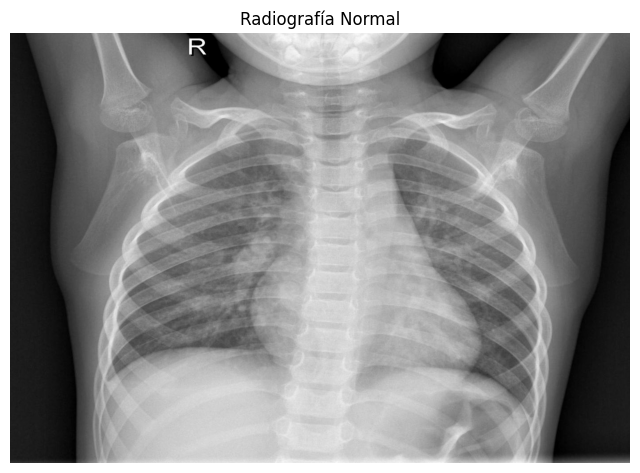

In [7]:
title='Radiografía Normal'
path = '../data/train/NORMAL/IM-0115-0001.jpeg'
showImage(path = path, title=title)

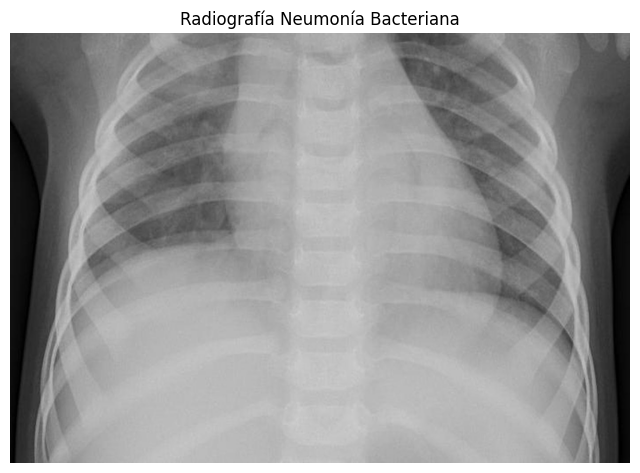

In [8]:
title='Radiografía Neumonía Bacteriana'
path = '../data/train/bacterialPneumonia/person1_bacteria_1.jpeg'
showImage(path = path, title=title)

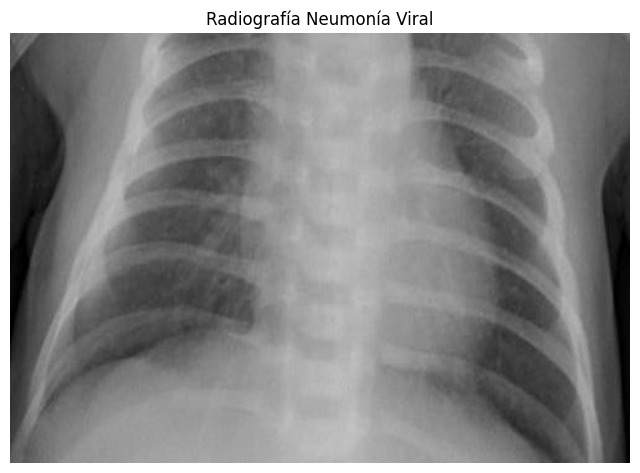

In [9]:
title='Radiografía Neumonía Viral'
path = '../data/train/virusPneumonia/person281_virus_578.jpeg'
showImage(path = path, title=title)

Como es evidente, cambio un poco el contraste y las dimensiones de las imagenes. Sin embargo, la extracción de características y la calsificación es ahora posible con los datos en este estandar de tamaño y canales

## 2. Rediseño de la partición

Como vimos en el análisis exploratorio, las particiones de datos estaban desbalanceadas. Por consiguiente, los datos se reunirán para identificar si existe un desbalanceo previo a la partición

In [10]:
sourceDestiny = [
    ('../data/train/Normal' , '../data/Normal'),
    ('../data/test/Normal' , '../data/Normal'),
    ('../data/val/Normal' , '../data/Normal'),
    ('../data/train/virusPneumonia' , '../data/virusPneumonia'),
    ('../data/test/virusPneumonia' , '../data/virusPneumonia'),
    ('../data/val/virusPneumonia' , '../data/virusPneumonia'),
    ('../data/train/bacterialPneumonia' , '../data/bacterialPneumonia'),
    ('../data/test/bacterialPneumonia' , '../data/bacterialPneumonia'),
    ('../data/val/bacterialPneumonia' , '../data/bacterialPneumonia')
]

for source, destiny in sourceDestiny:
    copyFiles(source,destiny)

1341 files copied from ../data/train/Normal to ../data/Normal
234 files copied from ../data/test/Normal to ../data/Normal
8 files copied from ../data/val/Normal to ../data/Normal
1345 files copied from ../data/train/virusPneumonia to ../data/virusPneumonia
148 files copied from ../data/test/virusPneumonia to ../data/virusPneumonia
0 files copied from ../data/val/virusPneumonia to ../data/virusPneumonia
2530 files copied from ../data/train/bacterialPneumonia to ../data/bacterialPneumonia
242 files copied from ../data/test/bacterialPneumonia to ../data/bacterialPneumonia
8 files copied from ../data/val/bacterialPneumonia to ../data/bacterialPneumonia


In [11]:
pathstoDelete = [
    '../data/train',
    '../data/test',
    '../data/val'
]
for path in pathstoDelete:
    deleteDirectoryAndContents(path)

Deleted directory and all contents: ../data/train
Deleted directory and all contents: ../data/test
Deleted directory and all contents: ../data/val


Ahora revisamos el balanceo de las clases en el conjunto completo de los datos

In [12]:
dirs = [
  '../data/bacterialPneumonia',
  '../data/virusPneumonia',
  '../data/Normal'
]

s = {}
for dir in dirs:
  keys = dir.split('/')[1:]
  if keys[0] not in s: s[keys[0]] = {}
  if keys[1] not in s[keys[0]]: s[keys[0]][keys[1]] = countFilesinFolder(dir)

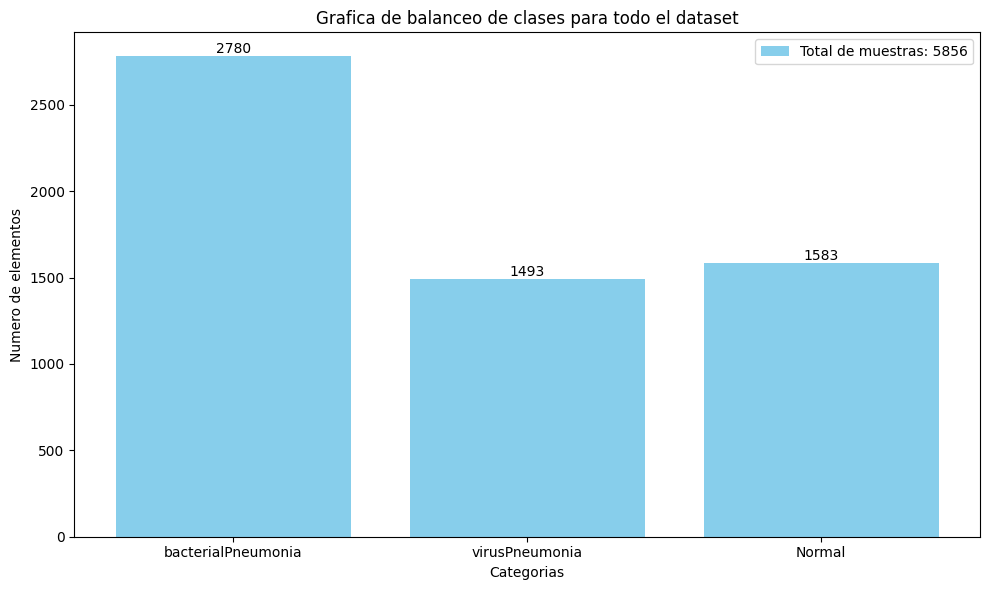

In [13]:
plotDataPartition(s['data'], 'Grafica de balanceo de clases para todo el dataset')

Como podemos ver el conjunto de datos de neumonía bacteriana tiene muchas más muestras contra las otras dos clases, vamos a realizar un submuestreo de la misma. De dicha clase, se seleccionarán 1500 muestras de manera aleatoria

In [14]:
path = '../data/bacterialPneumonia'
selected_images = underSampling(path,1500,seed=42)
deleteUnselectedImages(path,selected_images)

A total of 1500 files were sampled
A total of 1280 images were deleted


Ahora vamos a ver como quedo la grafica del balanceo de clases después de este ejercicio

In [17]:
dirs = [
  '../data/bacterialPneumonia',
  '../data/virusPneumonia',
  '../data/Normal'
]

s = {}
for dir in dirs:
  keys = dir.split('/')[1:]
  if keys[0] not in s: s[keys[0]] = {}
  if keys[1] not in s[keys[0]]: s[keys[0]][keys[1]] = countFilesinFolder(dir)

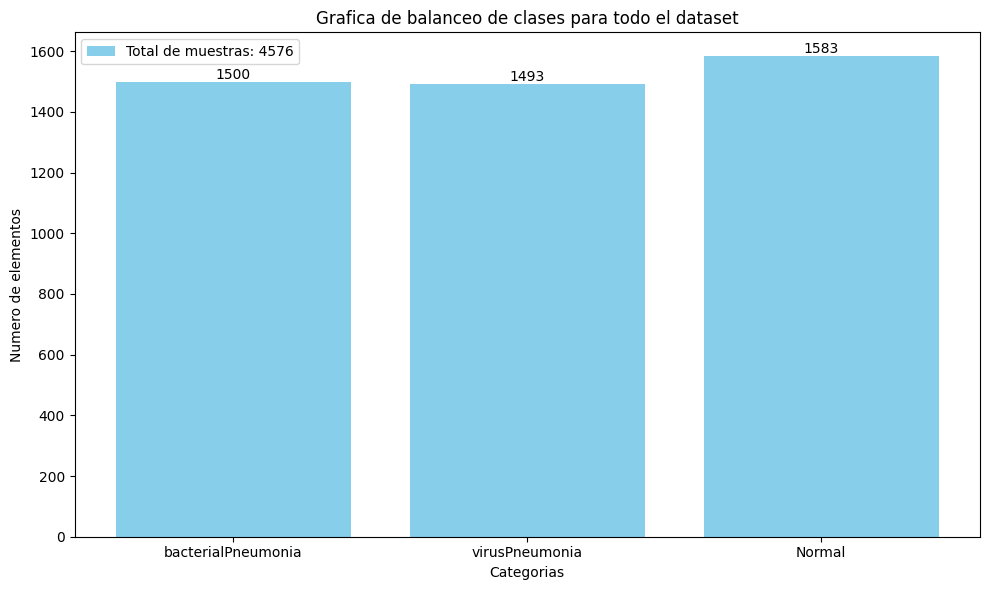

In [18]:
plotDataPartition(s['data'], 'Grafica de balanceo de clases para todo el dataset')

Con este cambio, ya las clases quedaron balanceados.

Ya con esto damos cierre a la etapa de preprocsamiento. Se balancearon las clases para la tarea de clasificación; y se modificaron las imagenes para que tengan las mismas dimensiones y la misma cantidad de canales